In [1]:
import CairoMakie as CM
import Plots
import DataFrames as DF
import CSV
import FileIO
import StatsPlots
using Chain

Plots.gr()
CM.set_theme!(CM.theme_ggplot2())

In [2]:
U_isotopes = [234,235,236,238,239,240]
Pu_isotopes = [238, 239, 240, 241, 242, 243, 244]
pucolumns = ["cycle_time", "separation_factor", ["Pu$(x)" for x = Pu_isotopes]...]
ucolumns = ["cycle_time", "separation_factor", ["U$(x)" for x = U_isotopes]...]

cyclerichment_alliso = DF.DataFrame(CSV.File("data/concentrations_cycletime.csv"))
hegseg = DF.DataFrame(CSV.File("data/concentrations_cycletime_heg_seg_m.csv"))
DF.names(hegseg)

430-element Vector{String}:
 "cycle_time"
 "high_enrichment_grade"
 "slight_enrichment_grade"
 "DepletedUraniumSink_360830000"
 "DepletedUraniumSink_420950000"
 "DepletedUraniumSink_430990000"
 "DepletedUraniumSink_440990000"
 "DepletedUraniumSink_441010000"
 "DepletedUraniumSink_441030000"
 "DepletedUraniumSink_441060000"
 "DepletedUraniumSink_451030000"
 "DepletedUraniumSink_451050000"
 "DepletedUraniumSink_451060000"
 ⋮
 "SeparatedWasteSink_932370000"
 "SeparatedWasteSink_932390000"
 "SeparatedWasteSink_942380000"
 "SeparatedWasteSink_942390000"
 "SeparatedWasteSink_942400000"
 "SeparatedWasteSink_942410000"
 "SeparatedWasteSink_942420000"
 "SeparatedWasteSink_952410000"
 "total_mass_DepletedUraniumSink"
 "total_mass_PlutoniumSink"
 "total_mass_SR_Reactor"
 "total_mass_SeparatedWasteSink"

In [5]:
function slice_by(df, col, valrange::Tuple{Real,Real})
   DF.filter(col => (x -> valrange[1] < x < valrange[2]), df) 
end

slice_by (generic function with 1 method)

In [6]:
function only_elem(df, elem::Integer, nix=3)
    DF.select(df, DF.Between(1, nix), Regex("_$(elem).+|total_mass"))
end
function only_elems(df, elems, nix=3)
    DF.select(df, DF.Between(1, nix), [Regex("_$(elem).+|total_mass") for elem in elems]...)
end

only_elems (generic function with 2 methods)

In [7]:
function total_mass(df, sink, elem=nothing, nix=3)
    if elem !== nothing
        return DF.select(df, DF.Between(1, nix), DF.All(), Regex("^$(sink)_$(elem).+") => (+) => "total_mass_$(sink)_$elem")
    end
    DF.select(df, DF.Between(1, nix), DF.All(), Regex("^$(sink)_.+") => (+) => "total_mass_$(sink)")
end

total_mass (generic function with 3 methods)

In [8]:
function isocode_to_iso(iso)
    if iso > 1e5
        elem = round(Int, iso/1e7)
        mass = round(Int, (iso - (elem*1e7)) / 1e4)
    else
        elem = round(Int, iso/1e3)
        mass = round(Int, (iso - elem * 1e3))
    end
    elem, mass
end

isocode_to_iso (generic function with 1 method)

In [9]:
function elemid_to_str(id)
    Dict(
        38 => "Sr",
        55 => "Cs",
        92 => "U",
        93 => "Np",
        94 => "Pu")[id]
end

elemid_to_str (generic function with 1 method)

## plots

by fresh fuel enrichment respectively cycle time

### by product enrichment

In [10]:
for_prod_enrichment = @chain hegseg begin
    only_elems([92,94])
    slice_by(:cycle_time, (60, 62))
    slice_by(:slight_enrichment_grade, (1.08, 1.12))
    total_mass("DepletedUraniumSink", 92)
    total_mass("SeparatedWasteSink", 94)
    total_mass("SeparatedWasteSink", 92)
    end;

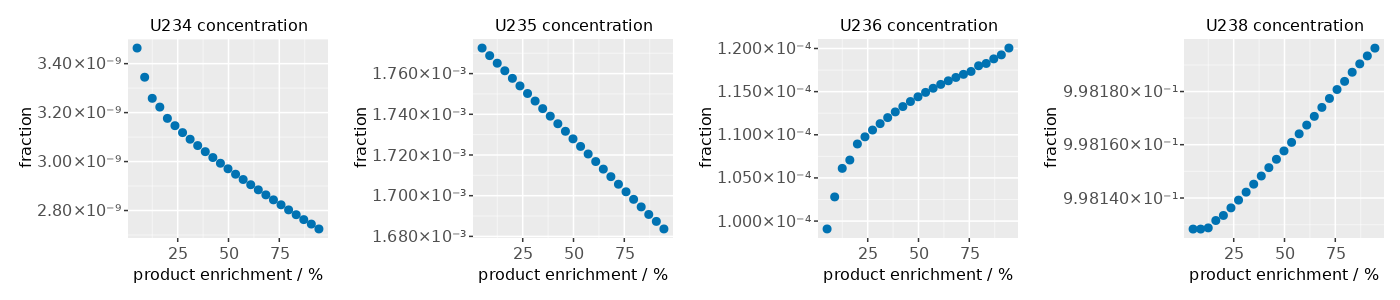

In [158]:
fig = CM.Figure(resolution=(1400, 300))

for (i, iso) in enumerate([234,235,236,238])
    ax = CM.Axis(fig[1, i], title="U$iso concentration", ylabel="fraction", xlabel="product enrichment / %")
    StatsPlots.@df for_prod_enrichment CM.scatter!(ax, :high_enrichment_grade, view(for_prod_enrichment, :, "DepletedUraniumSink_92$(iso)0000") ./ :total_mass_DepletedUraniumSink_92)
end
CM.save("out/prodenrich_depleteduraniumsink_concentrations.pdf", fig)
fig

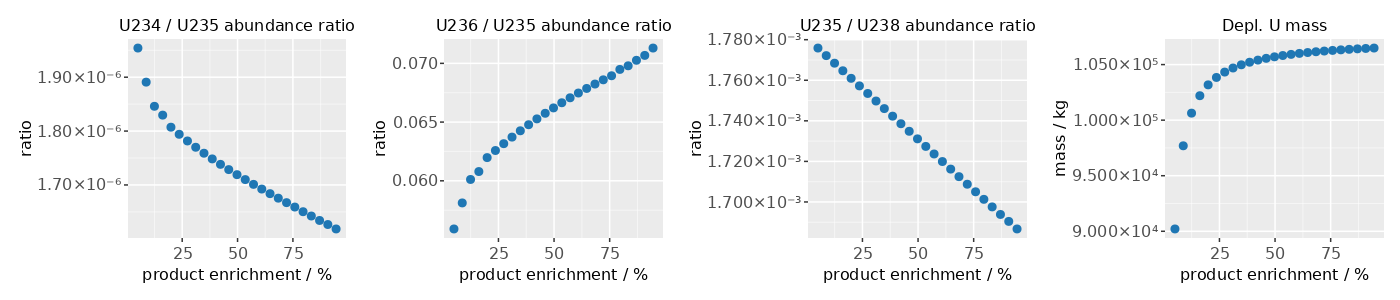

In [162]:
# same but for abundance ratios
fig = CM.Figure(resolution=(1400, 300), title="DepletedUraniumSink")

for (i,(iso1, iso2)) in enumerate([(234,235),(236,235),(235,238)])
    ax = CM.Axis(fig[1, i], title="U$iso1 / U$iso2 abundance ratio", ylabel="ratio", xlabel="product enrichment / %")
    StatsPlots.@df for_prod_enrichment CM.scatter!(ax, :high_enrichment_grade,
        view(for_prod_enrichment, :, "DepletedUraniumSink_92$(iso1)0000") ./ view(for_prod_enrichment, :, "DepletedUraniumSink_92$(iso2)0000"), color="#1f77b4", markercolor="#1f77b4")
end

ax = CM.Axis(fig[1,4], title="Depl. U mass", ylabel="mass / kg", xlabel="product enrichment / %")
StatsPlots.@df for_prod_enrichment CM.scatter!(ax, :high_enrichment_grade, view(for_prod_enrichment, :, "total_mass_DepletedUraniumSink"), color="#1f77b4", markercolor="#1f77b4")

CM.save("out/depleted_uranium_sink_u_abundanceratio_by_prodenrich.pdf", fig)
fig

### by fresh fuel enrichment

In [11]:
for_fresh_enrichment = @chain hegseg begin
    only_elems([92,94])
    slice_by(:cycle_time, (59,62))
    slice_by(:high_enrichment_grade, (88, 92))
    total_mass("DepletedUraniumSink", 92)
    total_mass("SeparatedWasteSink", 94)
    total_mass("SeparatedWasteSink", 92)
    end;

In [43]:
DF.select(for_fresh_enrichment, r"total_mass_DepletedUraniumSink$")

25×1 DataFrame
 Row │ total_mass_DepletedUraniumSink 
     │ Float64                        
─────┼────────────────────────────────
   1 │                      1.06564e5
   2 │                      1.06492e5
   3 │                      1.06452e5
   4 │                      1.06417e5
   5 │                      1.0638e5
   6 │                      1.06305e5
   7 │                      1.06263e5
   8 │                      1.06227e5
   9 │                      1.06187e5
  10 │                      1.06147e5
  11 │                      1.06071e5
  ⋮  │               ⋮
  16 │                      1.05828e5
  17 │                      1.05783e5
  18 │                      1.05743e5
  19 │                      1.057e5
  20 │                      1.05657e5
  21 │                      1.05614e5
  22 │                      1.05572e5
  23 │                      1.05488e5
  24 │                      1.05448e5
  25 │                      1.05404e5
                        4 rows omitted

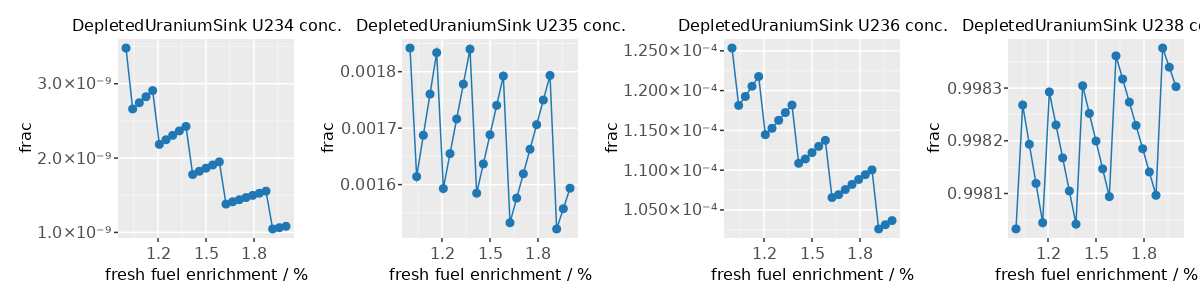

In [145]:
fig = CM.Figure(resolution=(1200, 300))
count = 1
for (j, sink) in enumerate(["DepletedUraniumSink"])
for (i,iso) in enumerate([234,235,236,238])
    ax = CM.Axis(fig[j, i], title="$(sink) U$iso conc.", ylabel="frac", xlabel="fresh fuel enrichment / %")
    StatsPlots.@df for_fresh_enrichment CM.scatterlines!(ax, :slight_enrichment_grade,
        view(for_fresh_enrichment, :, "$(sink)_92$(iso)0000"), color="#1f77b4", markercolor="#1f77b4")
    count += 1
end
end

CM.save("out/u_concs_by_freshenrichment.pdf", fig)
fig

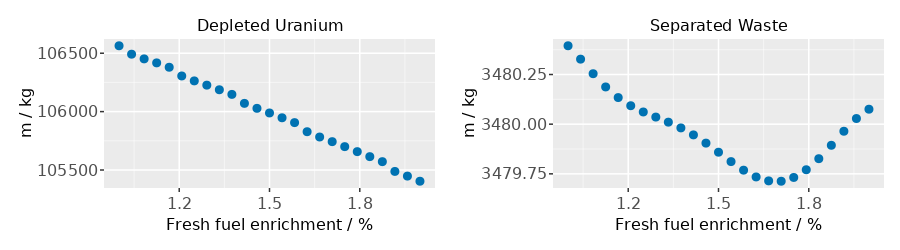

In [185]:
fig = CM.Figure(resolution=(900, 250))
ax1 = CM.Axis(fig[1,1],  title="Depleted Uranium", xlabel="Fresh fuel enrichment / %", ylabel="m / kg")
ax2 = CM.Axis(fig[1,2], title="Separated Waste", xlabel="Fresh fuel enrichment / %", ylabel="m / kg")

StatsPlots.@df for_fresh_enrichment CM.scatter!(ax1, :slight_enrichment_grade, :total_mass_DepletedUraniumSink)
StatsPlots.@df for_fresh_enrichment CM.scatter!(ax2, :slight_enrichment_grade, :total_mass_SeparatedWasteSink)
CM.save("out/cyclerichmentffe_mass.pdf", fig)
fig

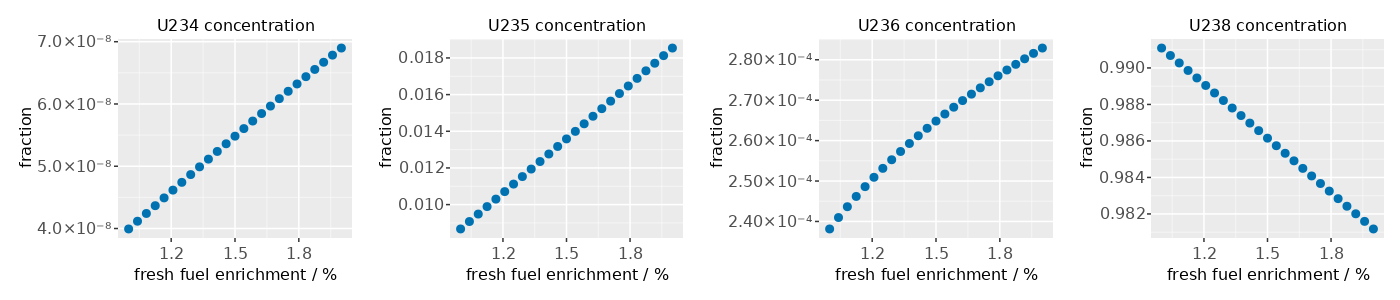

In [187]:
fig = CM.Figure(resolution=(1400, 300))

for (i, iso) in enumerate([234,235,236,238])
    ax = CM.Axis(fig[1, i], title="U$iso concentration", ylabel="fraction", xlabel="fresh fuel enrichment / %")
    StatsPlots.@df for_fresh_enrichment CM.scatter!(ax, :slight_enrichment_grade, view(for_fresh_enrichment, :, "SeparatedWasteSink_92$(iso)0000")./ :total_mass_SeparatedWasteSink_92)
end
#CM.save("out/SeparatedWasteSink_isotope_concentrations.pdf", fig)
fig

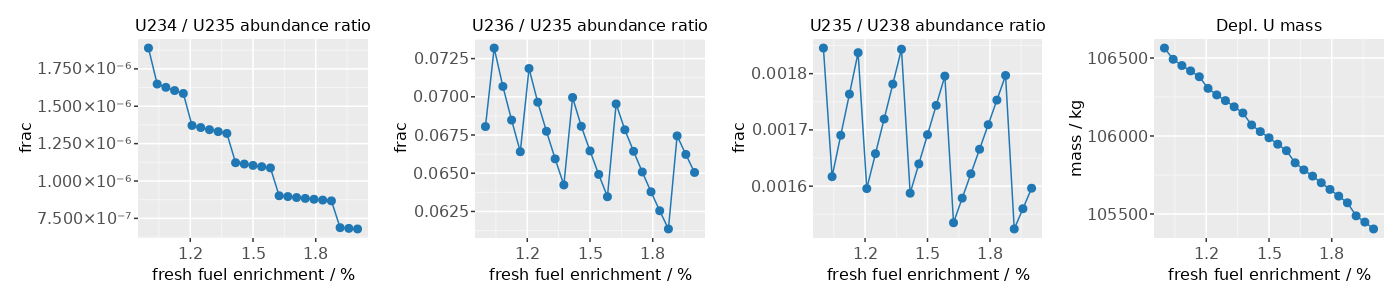

In [151]:
# same but for abundance ratios
fig = CM.Figure(resolution=(1400, 300), title="DepletedUraniumSink")

for (i,(iso1, iso2)) in enumerate([(234,235),(236,235),(235,238)])
    ax = CM.Axis(fig[1, i], title="U$iso1 / U$iso2 abundance ratio", ylabel="frac", xlabel="fresh fuel enrichment / %")
    StatsPlots.@df for_fresh_enrichment CM.scatterlines!(ax, :slight_enrichment_grade,
        view(for_fresh_enrichment, :, "DepletedUraniumSink_92$(iso1)0000") ./ view(for_fresh_enrichment, :, "DepletedUraniumSink_92$(iso2)0000"), color="#1f77b4", markercolor="#1f77b4")
end

ax = CM.Axis(fig[1,4], title="Depl. U mass", ylabel="mass / kg", xlabel="fresh fuel enrichment / %")
StatsPlots.@df for_fresh_enrichment CM.scatterlines!(ax, :slight_enrichment_grade, view(for_fresh_enrichment, :, "total_mass_DepletedUraniumSink"), color="#1f77b4", markercolor="#1f77b4")

CM.save("out/depleted_uranium_sink_u_abundanceratio_by_freshenrichment.pdf", fig)
fig

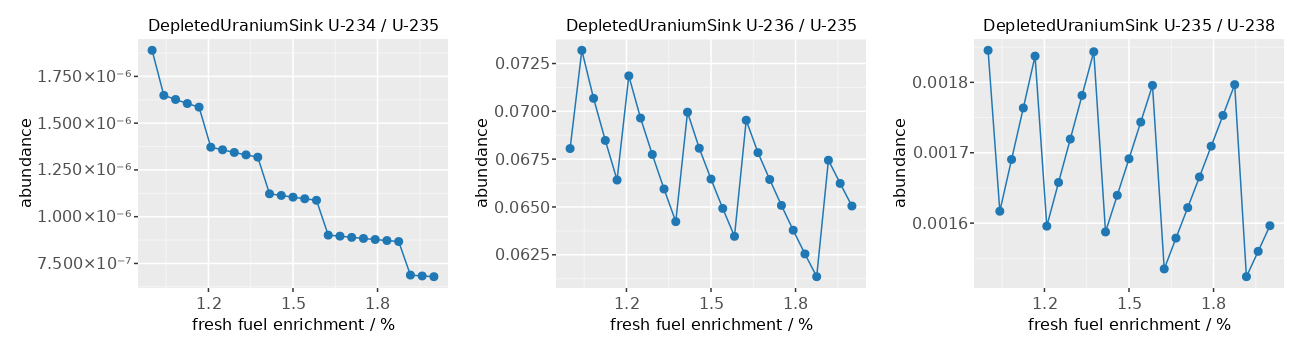

In [135]:
# 92234:92235,92236:92235,92235:92238,93240:93239,92235:94239,94239:94240,55135:55137,55134:55137,55133:55137,38088:38090,38086:38090

fig = CM.Figure(resolution=(1300, 350))

count = 1
for (j, sink) in enumerate(["DepletedUraniumSink"])
    for (i, iso) in enumerate([(92234,92235), (92236,92235), (92235,92238), (92235,94239), (94239,94240)])
        top, bottom = isocode_to_iso(iso[1]), isocode_to_iso(iso[2])
        topelem, bottomelem = elemid_to_str(top[1]), elemid_to_str(bottom[1])
        topname = "$(sink)_$(iso[1])0000"
        bottomname = "$(sink)_$(iso[2])0000"
        
        if !in(topname, DF.names(for_fresh_enrichment)) || !in(bottomname, DF.names(for_fresh_enrichment))
            continue
        end
        ax = CM.Axis(fig[1+div(count-1, 4), 1+(count-1)%4], title="$sink $(topelem)-$(top[2]) / $(bottomelem)-$(bottom[2])", ylabel="abundance", xlabel="fresh fuel enrichment / %")
        StatsPlots.@df for_fresh_enrichment CM.scatterlines!(ax, :slight_enrichment_grade,
            view(for_fresh_enrichment, :, topname ) ./ 
            view(for_fresh_enrichment, :, bottomname ), color="#1f77b4", markercolor="#1f77b4")
        count += 1
    end
end

CM.save("out/depleteduranium_abundances_by_freshenrichment.pdf", fig)
fig

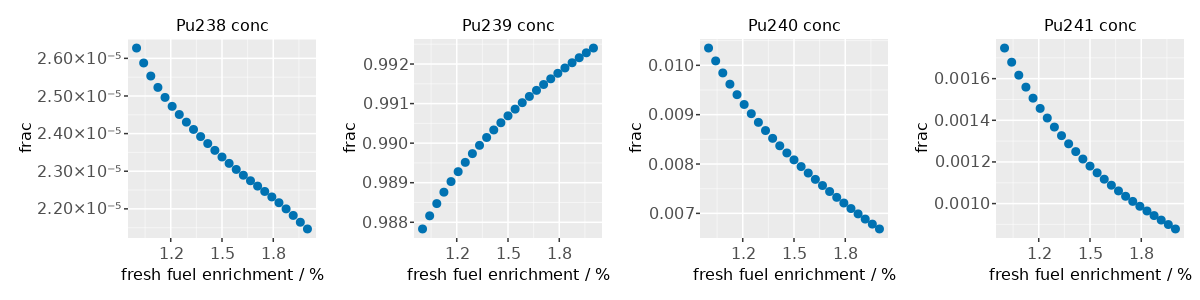

In [143]:
# Pu concentrations in Separated Waste by fresh fuel enrichment

fig = CM.Figure(resolution=(1200, 300))

for (i,iso) in enumerate([238,239,240,241])
    ax = CM.Axis(fig[1+div(i-1,4), 1+(i-1)%4], title="Pu$iso conc", ylabel="frac", xlabel="fresh fuel enrichment / %")
    StatsPlots.@df for_fresh_enrichment CM.scatter!(ax, :slight_enrichment_grade, view(for_fresh_enrichment, :, "SeparatedWasteSink_94$(iso)0000") ./ :total_mass_SeparatedWasteSink_94)
end

CM.save("out/separated_waste_sink_pu_concs_by_freshenrichment.pdf", fig)
fig

In [ ]:
for_ = @chain hegseg begin
    slice_by(:slight_enrichment_grade, (1.08, 1.12))
    total_mass("DepletedUraniumSink")
    total_mass("SeparatedWasteSink")
end
ravel_column(for_cyclerichment, :DepletedUraniumSink_922350000, :cycle_time, :high_enrichment_grade)
#DF.groupby(for_cyclerichment, :cycle_time)[1][1]

### by cycle time

In [14]:
for_cycle_time = @chain hegseg begin
    only_elems([92,94])
    slice_by(:high_enrichment_grade, (89,91))
    slice_by(:slight_enrichment_grade, (1.08, 1.12))
    total_mass("DepletedUraniumSink", 92)
    total_mass("SeparatedWasteSink", 94)
    total_mass("SeparatedWasteSink", 92)
    end

25×41 DataFrame
 Row │ cycle_time  high_enrichment_grade  slight_enrichment_grade  DepletedUra ⋯
     │ Float64     Float64                Float64                  Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    20.0                   90.7708                  1.08333              ⋯
   2 │    24.1667                90.7708                  1.08333
   3 │    28.3333                90.7708                  1.08333
   4 │    32.5                   90.7708                  1.08333
   5 │    36.6667                90.7708                  1.08333              ⋯
   6 │    40.8333                90.7708                  1.08333
   7 │    45.0                   90.7708                  1.08333
   8 │    49.1667                90.7708                  1.08333
   9 │    53.3333                90.7708                  1.08333              ⋯
  10 │    57.5                   90.7708                  1.08333
  11 │    61.6667                90.7708                  1.08333
  ⋮  │     ⋮                 ⋮                       ⋮                         ⋱
  16 │    82.5                   90.7708                  1.08333
  17 │    86.6667                90.7708                  1.08333              ⋯
  18 │    90.8333                90.7708                  1.08333
  19 │    95.0                   90.7708                  1.08333
  20 │    99.1667                90.7708                  1.08333
  21 │   103.333                 90.7708                  1.08333              ⋯
  22 │   107.5                   90.7708                  1.08333
  23 │   111.667                 90.7708                  1.08333
  24 │   115.833                 90.7708                  1.08333
  25 │   120.0                   90.7708                  1.08333              ⋯
                                                   38 columns and 4 rows omitted

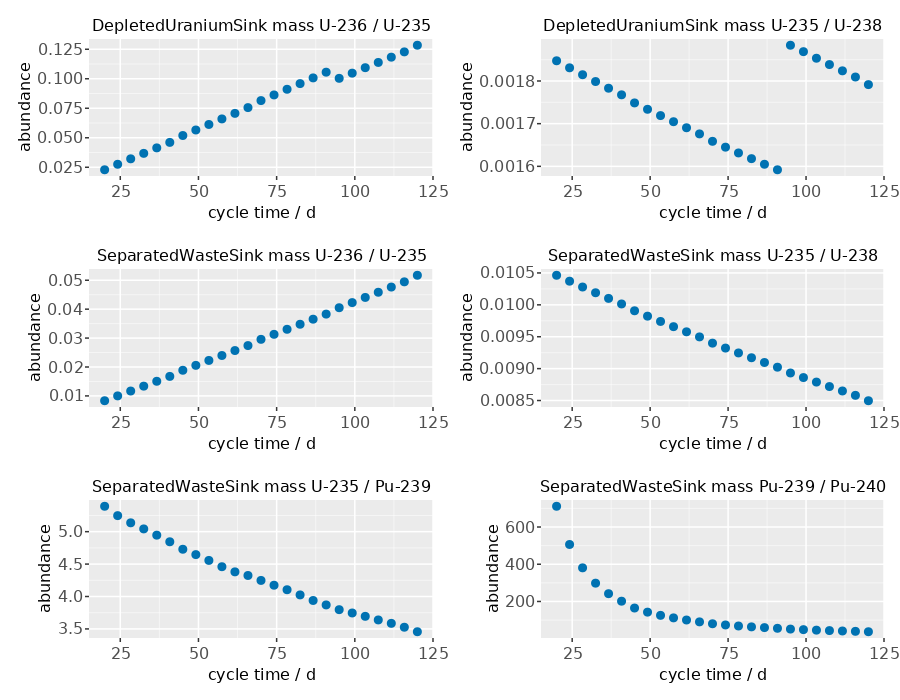

In [15]:
# plot used abundances
# 92234:92235,92236:92235,92235:92238,93240:93239,92235:94239,94239:94240,55135:55137,55134:55137,55133:55137,38088:38090,38086:38090

fig = CM.Figure(resolution=(900, 700))

count = 1
for (j, sink) in enumerate(["DepletedUraniumSink", "SeparatedWasteSink"])
    for (i, iso) in enumerate([(92236,92235), (92235,92238), (92235,94239), (94239,94240)])
        top, bottom = isocode_to_iso(iso[1]), isocode_to_iso(iso[2])
        topelem, bottomelem = elemid_to_str(top[1]), elemid_to_str(bottom[1])
        topname = "$(sink)_$(iso[1])0000"
        bottomname = "$(sink)_$(iso[2])0000"
        
        if !in(topname, DF.names(for_cycle_time)) || !in(bottomname, DF.names(for_cycle_time))
            continue
        end
        ax = CM.Axis(fig[1+div(count-1, 2), 1+(count-1)%2], title="$sink mass $(topelem)-$(top[2]) / $(bottomelem)-$(bottom[2])", ylabel="abundance", xlabel="cycle time / d")
        StatsPlots.@df for_cycle_time CM.scatter!(ax, :cycle_time,
            view(for_cycle_time, :, topname ) ./ 
            view(for_cycle_time, :, bottomname ))
        count += 1
    end
end

CM.save("out/abundances_by_cycletime.pdf", fig)
fig

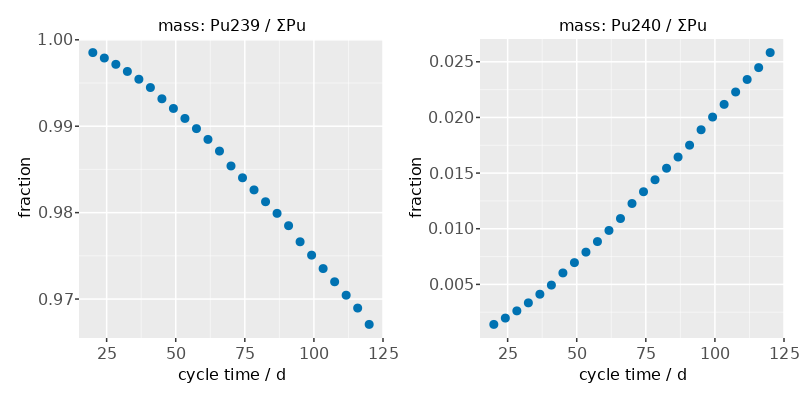

In [190]:
fig = CM.Figure(resolution=(800, 400))

for (i, iso) in enumerate([239, 240])
    ax = CM.Axis(fig[1+div(i-1, 2), 1+(i-1)%2], title="mass: Pu$iso / ΣPu", ylabel="fraction", xlabel="cycle time / d")
    StatsPlots.@df for_cycle_time CM.scatter!(ax, :cycle_time, view(for_cycle_time, :, "SeparatedWasteSink_94$(iso)0000") ./ :total_mass_SeparatedWasteSink_94)
end

CM.save("out/separated_waste_sink_pu_concs_by_cycletime.pdf", fig)
fig

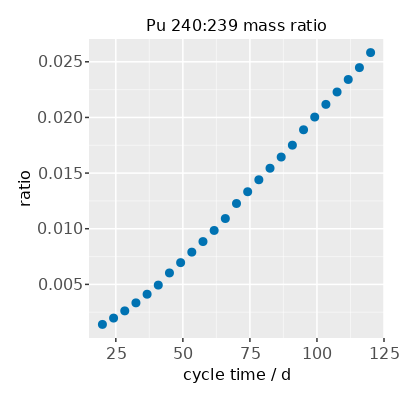

In [18]:
fig = CM.Figure(resolution=(400, 400))

ax = CM.Axis(fig[1,1], title="Pu 240:239 mass ratio", ylabel="ratio", xlabel="cycle time / d")
StatsPlots.@df for_cycle_time CM.scatter!(ax, :cycle_time, :SeparatedWasteSink_942400000 ./ :total_mass_SeparatedWasteSink_94)

CM.save("out/separated_waste_sink_pu_240_ratio.pdf", fig)
fig

In [170]:
for_cycle_time

25×40 DataFrame
 Row │ cycle_time  high_enrichment_grade  slight_enrichment_grade  DepletedUra ⋯
     │ Float64     Float64                Float64                  Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    20.0                   90.7708                  1.08333              ⋯
   2 │    24.1667                90.7708                  1.08333
   3 │    28.3333                90.7708                  1.08333
   4 │    32.5                   90.7708                  1.08333
   5 │    36.6667                90.7708                  1.08333              ⋯
   6 │    40.8333                90.7708                  1.08333
   7 │    45.0                   90.7708                  1.08333
   8 │    49.1667                90.7708                  1.08333
   9 │    53.3333                90.7708                  1.08333              ⋯
  10 │    57.5                   90.7708                  1.08333
  11 │    61.6667                90.7708                  1.08333
  ⋮  │     ⋮                 ⋮                       ⋮                         ⋱
  16 │    82.5                   90.7708                  1.08333
  17 │    86.6667                90.7708                  1.08333              ⋯
  18 │    90.8333                90.7708                  1.08333
  19 │    95.0                   90.7708                  1.08333
  20 │    99.1667                90.7708                  1.08333
  21 │   103.333                 90.7708                  1.08333              ⋯
  22 │   107.5                   90.7708                  1.08333
  23 │   111.667                 90.7708                  1.08333
  24 │   115.833                 90.7708                  1.08333
  25 │   120.0                   90.7708                  1.08333              ⋯
                                                   37 columns and 4 rows omitted

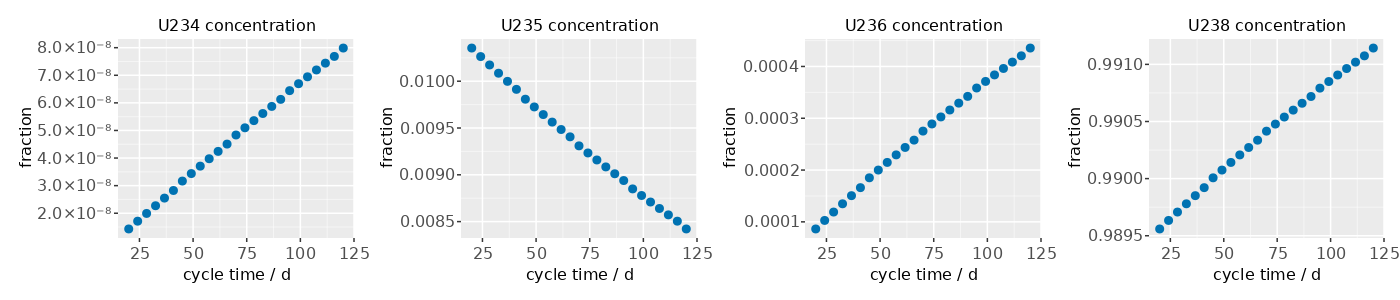

In [173]:
fig = CM.Figure(resolution=(1400, 300))

for (i, iso) in enumerate([234,235,236,238])
    ax = CM.Axis(fig[1, i], title="U$iso concentration", ylabel="fraction", xlabel="cycle time / d")
    StatsPlots.@df for_cycle_time CM.scatter!(ax, :cycle_time, view(for_cycle_time, :, "SeparatedWasteSink_92$(iso)0000")./ :total_mass_SeparatedWasteSink_92)
end
#CM.save("out/SeparatedWasteSink_isotope_concentrations.pdf", fig)
fig

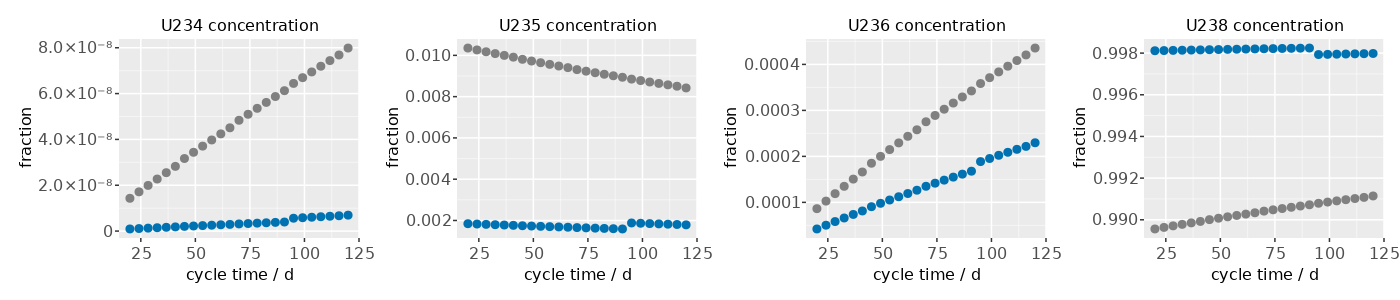

In [184]:
fig = CM.Figure(resolution=(1400, 300))

for (i, iso) in enumerate([234,235,236,238])
    ax = CM.Axis(fig[1, i], title="U$iso concentration", ylabel="fraction", xlabel="cycle time / d")
    StatsPlots.@df for_cycle_time CM.scatter!(ax, :cycle_time, view(for_cycle_time, :, "DepletedUraniumSink_92$(iso)0000")./ :total_mass_DepletedUraniumSink_92, label="depl. U")
    StatsPlots.@df for_cycle_time CM.scatter!(ax, :cycle_time, view(for_cycle_time, :, "SeparatedWasteSink_92$(iso)0000")./ :total_mass_SeparatedWasteSink_92, color=:gray, label="feed")
end

CM.save("out/depleteduraniumsink_isotope_concentrations.pdf", fig)
fig

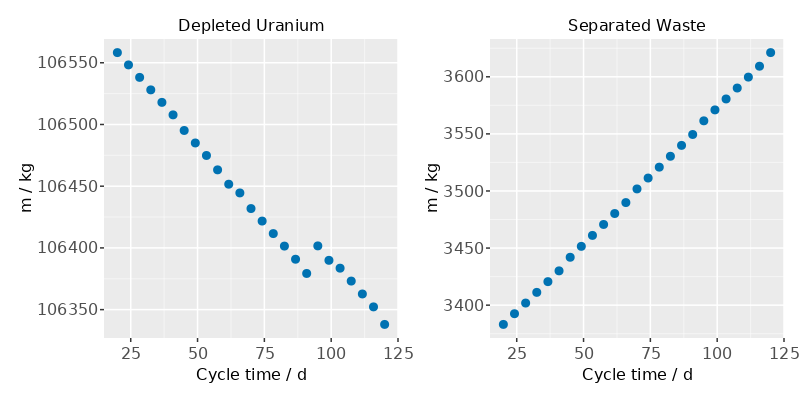

In [69]:
fig = CM.Figure(resolution=(800, 400))
ax1 = CM.Axis(fig[1,1],  title="Depleted Uranium", xlabel="Cycle time / d", ylabel="m / kg")
ax2 = CM.Axis(fig[1,2], title="Separated Waste", xlabel="Cycle time / d", ylabel="m / kg")

StatsPlots.@df for_cycle_time CM.scatter!(ax1, :cycle_time, :total_mass_DepletedUraniumSink)
StatsPlots.@df for_cycle_time CM.scatter!(ax2, :cycle_time, :total_mass_SeparatedWasteSink)
CM.save("out/cycletime_mass.pdf", fig)
fig

### cyclerichment

In [35]:
function ravel_column(df, column, ix1, ix2)
    dim1 = size(DF.groupby(df, ix1)[1])[1]
    dim2 = size(DF.groupby(df, ix2)[1])[1]
    
    raw = @view df[!, column]
    reshape(raw, dim1, dim2)'
end

ravel_column (generic function with 1 method)

In [36]:
for_cyclerichment = @chain hegseg begin
    slice_by(:slight_enrichment_grade, (1.08, 1.12))
end
ravel_column(for_cyclerichment, :DepletedUraniumSink_922350000, :cycle_time, :high_enrichment_grade)
#DF.groupby(for_cyclerichment, :cycle_time)[1][1]

25×25 adjoint(reshape(view(::Vector{Float64}, :), 25, 25)) with eltype Float64:
 0.0019365   0.00193247  0.00192844  …  0.00184789  0.00184387  0.00183984
 0.00191934  0.00191534  0.00191134     0.00183144  0.00182745  0.00182346
 0.00190245  0.00189848  0.00189452     0.00181526  0.0018113   0.00180734
 0.00188583  0.00188189  0.00187796     0.00179932  0.0017954   0.00179154
 0.00186946  0.00186556  0.00186165     0.0017837   0.00177974  0.00177606
 0.00185335  0.00184947  0.0018456   …  0.0017682   0.00176433  0.00176046
 0.00183355  0.00182971  0.00182587     0.00174922  0.00174539  0.00174156
 0.00181797  0.00181416  0.00181035     0.00173429  0.00173049  0.00172669
 0.00180262  0.00179883  0.00179505     0.00171958  0.00171581  0.00171208
 0.00178748  0.00178373  0.00177998     0.00170508  0.00170149  0.00169777
 0.00177256  0.00176883  0.00176511  …  0.00169078  0.00168736  0.00168365
 0.00175784  0.00175414  0.00175044     0.00167667  0.00167299  0.00166972
 0.00173971  0.00173

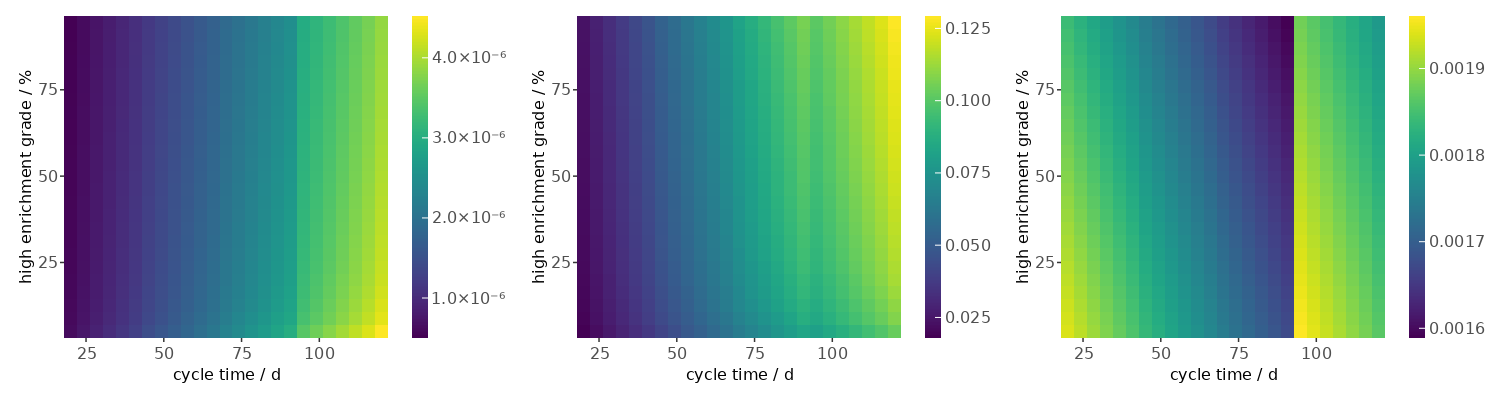

In [37]:
fig = CM.Figure(resolution=(1500, 400))


for (i, iso) in enumerate([(234,235),(236,235), (235,238)])
   ax = CM.Axis(fig[div((i-1), 3)+1,  2 * ((i-1)%3) + 1], xlabel="cycle time / d", ylabel="high enrichment grade / %")
    matrix1 = ravel_column(for_cyclerichment, "DepletedUraniumSink_92$(iso[1])0000", :cycle_time, :high_enrichment_grade)
    matrix2 = ravel_column(for_cyclerichment, "DepletedUraniumSink_92$(iso[2])0000", :cycle_time, :high_enrichment_grade)
    hm = StatsPlots.@df for_cyclerichment CM.heatmap!(ax, unique(:cycle_time), unique(:high_enrichment_grade), matrix1 ./ matrix2)
    cb = CM.Colorbar(fig[div((i-1), 3)+1,  2 * ((i-1)%3) + 2], hm)
end
fig

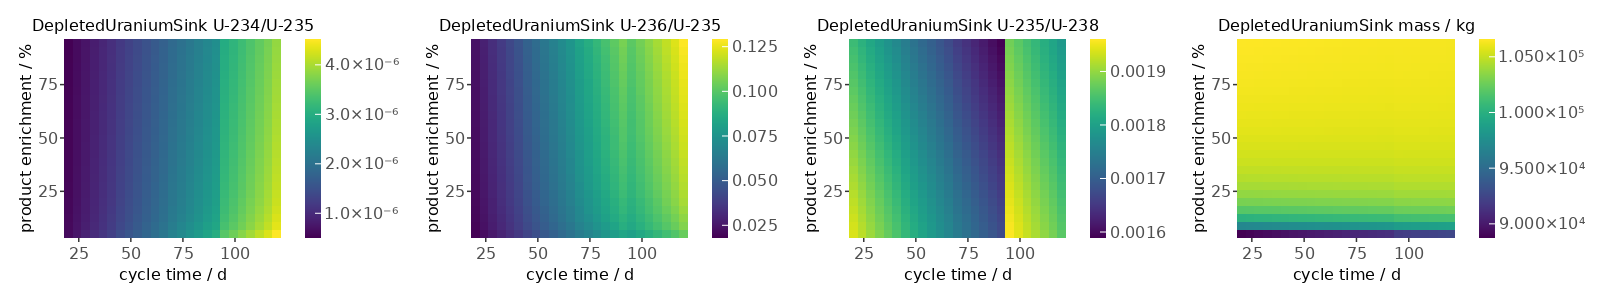

In [38]:
fig = CM.Figure(resolution=(1600, 300))
count = 1

for (j, sink) in enumerate(["DepletedUraniumSink"])
    for (i, iso) in enumerate([(92234,92235), (92236,92235), (92235,92238)])
        top, bottom = isocode_to_iso(iso[1]), isocode_to_iso(iso[2])
        topelem, bottomelem = elemid_to_str(top[1]), elemid_to_str(bottom[1])
        topname = "$(sink)_$(iso[1])0000"
        bottomname = "$(sink)_$(iso[2])0000"
        if !in(topname, DF.names(for_cyclerichment)) || !in(bottomname, DF.names(for_cyclerichment))
            continue
        end
        
        matrixtop = ravel_column(for_cyclerichment, topname, :cycle_time, :high_enrichment_grade)
        matrixbottom = ravel_column(for_cyclerichment, bottomname, :cycle_time, :high_enrichment_grade)

        ax = CM.Axis(fig[1+div(count-1, 3), 1+2*((count-1)%3)], title="$sink $topelem-$(top[2])/$bottomelem-$(bottom[2])", xlabel="cycle time / d", ylabel="product enrichment / %")
        hm = StatsPlots.@df for_cyclerichment CM.heatmap!(ax, unique(:cycle_time), unique(:high_enrichment_grade), matrixtop ./ matrixbottom)
        cb = CM.Colorbar(fig[div((count-1), 3)+1,  2 * ((count-1)%3) + 2], hm)
        count += 1
    end
end

ax = CM.Axis(fig[1,7], title="DepletedUraniumSink mass / kg", xlabel="cycle time / d", ylabel="product enrichment / %")
deplumass = ravel_column(for_cyclerichment, :total_mass_DepletedUraniumSink,
            :cycle_time, :high_enrichment_grade)
hm = StatsPlots.@df for_cyclerichment CM.heatmap!(ax, unique(:cycle_time), unique(:high_enrichment_grade), deplumass)
CM.Colorbar(fig[1,8], hm)
#ax = CM.Axis(fig[2,7], title="SeparatedWasteSink mass / kg", xlabel="cycle time / d", ylabel="product enrichment / %")
#sepwmass = ravel_column(for_cyclerichment, :total_mass_SeparatedWasteSink,
#            :cycle_time, :high_enrichment_grade)
#hm = StatsPlots.@df for_cyclerichment CM.heatmap!(ax, unique(:cycle_time), unique(:high_enrichment_grade), sepwmass)
#CM.Colorbar(fig[2,8], hm)

CM.save("out/cyclerichment_abundance.pdf", fig)
fig

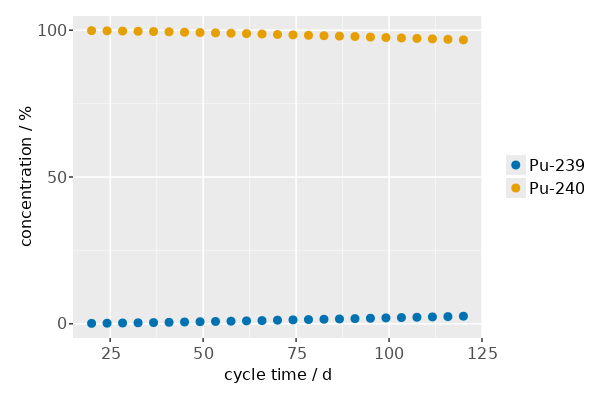

In [40]:
fig = CM.Figure(resolution=(600,400))
ax = CM.Axis(fig[1,1], xlabel="cycle time / d", ylabel="concentration / %")
sc1 = StatsPlots.@df for_cycle_time CM.scatter!(ax,:cycle_time, 100 .* for_cycle_time.SeparatedWasteSink_942400000 ./ for_cycle_time.total_mass_SeparatedWasteSink_94, label="Pu-239")
sc2 = StatsPlots.@df for_cycle_time CM.scatter!(ax,:cycle_time, 100 .* for_cycle_time.SeparatedWasteSink_942390000 ./ for_cycle_time.total_mass_SeparatedWasteSink_94, label="Pu-240")
CM.Legend(fig[1,2], [sc1, sc2], ["Pu-239", "Pu-240"])
CM.save("out/pu240_over_cycletime.pdf", fig)
fig

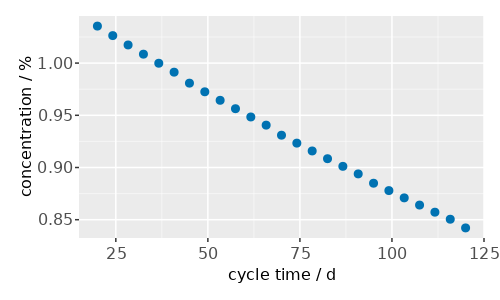

In [43]:
fig = CM.Figure(resolution=(500,300))
ax = CM.Axis(fig[1,1], xlabel="cycle time / d", ylabel="concentration / %")
sc1 = StatsPlots.@df for_cycle_time CM.scatter!(ax,:cycle_time, 100 .* for_cycle_time.SeparatedWasteSink_922350000 ./ for_cycle_time.total_mass_SeparatedWasteSink_92)
CM.save("out/u235_separated_waste.pdf", fig)
fig